# Setup 

In [7]:
import numpy as np


class UCB1:
    def __init__(self, num_arms: int, delta: float):
        self.t = 0
        self.num_arms = num_arms
        self.true_rewards = [0.5] + [1 - (0.5 - delta)] * (num_arms - 1)
        self.acc_regrets = []
        
        self.counts = np.zeros(num_arms)  # Number of times each arm is played
        self.values = np.zeros(num_arms)  # Total reward for each arm

    def select_arm(self) -> int:
        if self.t < self.num_arms:
            # If not all arms have been played at least once, play the next sequential arm
            arm = self.t
        else:
            ucb_values = self.values / self.counts
            confidence_bounds = np.sqrt((2 * np.log2(self.t)) / (2 * self.counts))
            ucb_values += confidence_bounds
            arm = np.argmax(ucb_values)
            
        return arm

    def update(self, chosen_arm: int):
        # Simulate the reward using Bernoulli distribution
        reward = np.random.binomial(1, self.true_rewards[chosen_arm])
        self.counts[chosen_arm] += 1
        self.values[chosen_arm] += reward

        # Calculate regret
        best_possible_reward = max(self.true_rewards)
        regret = best_possible_reward - self.true_rewards[chosen_arm]
        
        acc_regret = self.acc_regrets[self.t-1] if self.t > 0 else 0
        self.acc_regrets.append(acc_regret + regret)
        self.t += 1        

In [9]:
class LearningRate():
    def __init__(self, nA):
        self.nA = nA
        self._fn = lambda t: np.sqrt(np.log(self.nA) / (self.nA * t))
        self.t = 0
    
    def step(self):
        self.t += 1
        return self._fn(self.t)

class EXP3():
    def __init__(self, nA, delta, T):
        self.p_regret = np.zeros(T)
        self.nA = nA
        self.lr = LearningRate(nA)
        self.P = np.full(self.nA, 1 / self.nA)
        self.cum_loss = np.zeros(self.nA)
        self.t = 0
        self.expected_loss = 0
        self.loss_vector = np.zeros(self.nA)
        self.expected_losses = [0.5] + [0.5 - delta] * (nA - 1)
    
    def select_arm(self):
        return np.random.choice(self.nA, p=self.P)
    
    def update(self, a_t):
        eta = self.lr.step()
        l_t = np.random.binomial(1, p=self.expected_losses[a_t])
        l_tilde_t = l_t / self.P[a_t]
        self.cum_loss[a_t] += l_tilde_t

        self.expected_loss += self.expected_losses[a_t]
        self.loss_vector += self.expected_losses

        self.p_regret[self.t] = self.expected_loss - np.min(self.loss_vector)
        min_cum_loss = self.cum_loss - np.min(self.cum_loss)
        exp = np.exp(-eta * min_cum_loss)
        self.P = exp / np.sum(exp) 
        self.t += 1

In [14]:

class AdversarialBandit:
    def __init__(self, probs):
        self.probs = probs

    def draw(self, a):
        reward = np.random.binomial(1, self.probs[a])
        loss = np.max(self.probs) - self.probs[a]
        # Flip probs
        self.probs = np.roll(self.probs, 1)
        return reward, loss


deltas: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


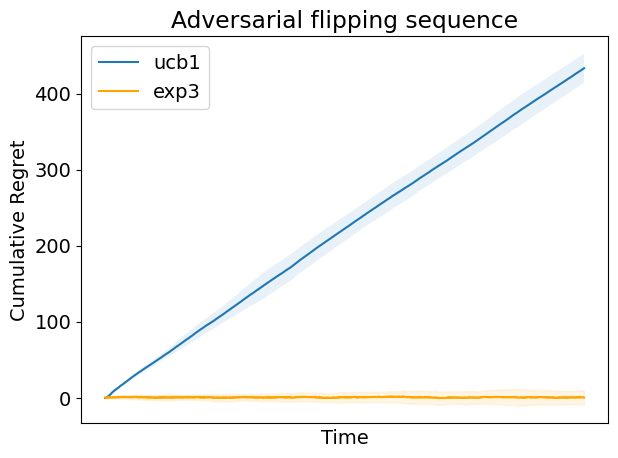

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # noqa: F811

plt.rcParams.update({'font.size': 14})

# Parameters
T = 1000# 00  # Total number of time steps
num_simulations = 20 # 20  # Number of simulations to run
K = [2]  # Number of arms
deltas = [1/4] # , 1/8, 1/16]  # Different values of delta

# Run simulations
for k in K:    
    #fig, axs = plt.subplots(1, len(deltas), figsize=(20, 8), sharey=True)
    # plt.suptitle(f'Performance Comparison for k = {k}', fontsize=24)
    for d, delta in tqdm(enumerate(deltas), desc='deltas', total=len(deltas)):
        results_ucb1 = []
        results_exp3 = []
        mab = AdversarialBandit([0.8, 0])
        for sim in tqdm(range(num_simulations), desc='simulations', total=num_simulations):            
            ucb1_stoch_instance = UCB1(k, T)
            exp3_stoch_instance = EXP3(k, LearningRate(k))
            
            ucb1_stoch_instance.train(mab)
            exp3_stoch_instance.train(T, mab)        
            results_ucb1.append(ucb1_stoch_instance.p_regret)                
            results_exp3.append(exp3_stoch_instance.p_regret)

        # Calculate mean, min, max for ucb1 UCB1
        regrets_ucb1 = np.array(results_ucb1)
        mean_ucb1 = regrets_ucb1.mean(axis=0)
        std_ucb1 = regrets_ucb1.std(axis=0)

        # Calculate mean, min, max for exp3 UCB1
        regrets_exp3 = np.array(results_exp3)
        mean_exp3 = regrets_exp3.mean(axis=0)
        std_exp3 = regrets_exp3.std(axis=0)

        # Time steps
        time_steps = np.arange(T)

        # Plot ucb1
        plt.plot(time_steps, mean_ucb1, label='ucb1')
        plt.fill_between(time_steps, mean_ucb1 - std_ucb1, mean_ucb1 + std_ucb1, alpha=0.1)

        # Plot exp3
        plt.plot(time_steps, mean_exp3, label='exp3', color='orange')
        plt.fill_between(time_steps, mean_exp3 - std_exp3, mean_exp3 + std_exp3, color='orange', alpha=0.1)
        x = int(1/delta)
        plt.title('Adversarial flipping sequence')
        plt.xticks([])
        
    plt.ylabel('Cumulative Regret')
    plt.xlabel('Time')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'artifacts/adversarial_ucb1_performance_k{k}_0_8.pdf')
    plt.show()